# Predicting Salaries in the Data Science Field Using Logistic Regression

In this project, the goal is to accurately predict whether the salaries for a set of job positions in the data science field are high or low based upon the location, job title, and job summary.  The input data for this exercise is entirely textual and relatively small, making a numerical linear regression to predict salaries impractical.  However, using logistic regression to predict a binary prediction of high or low salaries is still a reasonable goal.

In the exercise, I will apply logistic regression using the location as a dummy variable, along with binary variables for the presence of individual words or word pairs in the job titles and summaries.  I will fit the data set with a logistic regression, both with and without regularization applied.  I will begin with the simplest model of only location, and increase complexity in terms of the number of words tested for inclusion in the summary and title columns.

## Initial Data Parsing

In [1]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Data Set Summary

The data set for tis exercise contains 413 columns, though only 406 have usable values in the "parsed_salary" column.  The company and salary columns will be ignored throughout this analysis -- the salary column has been pre-parsed into the "parsed_salary" column, while the company column has too many unique values to be useful (see the histogram below).  I also drop the small number of entries with null values in the "parsed_salary" column.

In [2]:
jobs = pd.read_csv("assets/indeed-scraped-job-postings.csv")

In [3]:
print jobs.info()
print jobs.describe()
jobs.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 6 columns):
city             413 non-null object
company          413 non-null object
salary           413 non-null object
summary          413 non-null object
title            413 non-null object
parsed_salary    406 non-null float64
dtypes: float64(1), object(5)
memory usage: 19.4+ KB
None
       parsed_salary
count     406.000000
mean   107762.695813
std     48931.367632
min     10000.000000
25%     70000.000000
50%    100000.000000
75%    142164.500000
max    300000.000000


,city,company,salary,summary,title,parsed_salary
0,Denver,Department Of The Interior,"$76,341 - $99,243 a year","Would you like to join the more than 10,000 sc...","Statistician, GS-1350-12 (DEU-PERM-DS)",87792.0
1,Denver,Department Of The Interior,"$71,012 - $99,243 a year",Investigate potential uses of geospatial data ...,Interdisciplinary Cartographer/Geographer - GS...,85127.5
2,Denver,Mental Health Center of Denver,"$70,000 - $80,000 a year",Advise the Data Developer with regard to creat...,Financial Data Scientist,75000.0
3,Denver,Denver Public Schools,"$62,712 - $75,255 a year",Portal managers on student outcome data report...,SENIOR RESEARCH ANALYST,68983.5
4,Denver,University of Colorado,"$25,000 - $29,000 a year",Experience entering and manipulating data in a...,Animal Care I,27000.0


[]

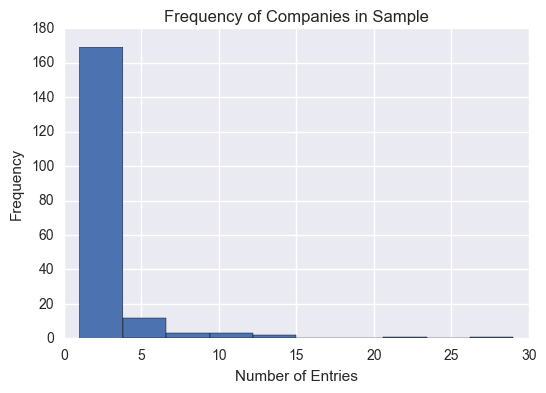

In [4]:
plt.hist(jobs.groupby(["company"]).agg("count")["city"])
plt.title("Frequency of Companies in Sample")
plt.xlabel("Number of Entries")
plt.ylabel("Frequency")
plt.plot()

In [5]:
jobs.dropna(inplace=True)

#### Definition of Classes

Here I will consider only the simplest case of two classes for the salary, separated into roughly two equal sizes.  The mean and median of salaries in the data set are given below; the median is exactly $100K, while the mean is only slighly above.  The boxplot of salaries indicates that there is a bit longer tail towards larger salaries, but generaly the classes of salaries above and below the median are fairly broad.  As such, I will use the median value as the dividing line between high and low salaries, with high and low salaries indicated by "1" and "0" respectively in the new "high_low" column of the data set.

Mean of parsed salaries: 107762.695813
Median of parsed salaries: 100000.0


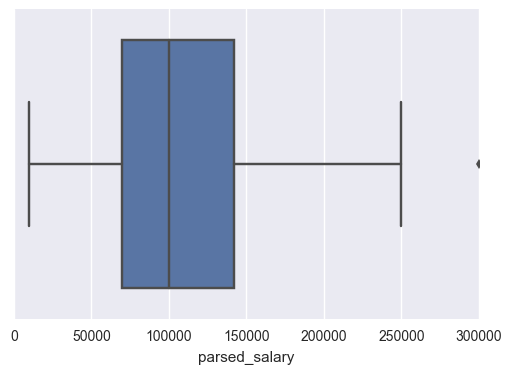

In [6]:
print "Mean of parsed salaries:",jobs["parsed_salary"].mean()
print "Median of parsed salaries:",jobs["parsed_salary"].median()
sns.boxplot(jobs["parsed_salary"])

In [7]:
jobs["high_low"] = jobs["parsed_salary"].apply(lambda x: int(x > jobs["parsed_salary"].median()))

#### Baseline Accuracy

Since this is a simple two-class problem, the baseline accuracy is given by the larger of the two classes.  This value is slighly above 50% because multiple entries lie precisely on the median dividing line.

In [8]:
class_sizes = list(jobs[jobs["parsed_salary"].isnull() == False].groupby("high_low").agg('count')["parsed_salary"])
baseline_accuracy = max(class_sizes) * 1.0 / sum(class_sizes)
print "The baseline accuracy is given by predicting all results to be in the most prominent class.\n\
In this case it is given by:",baseline_accuracy

The baseline accuracy is given by predicting all results to be in the most prominent class.
In this case it is given by: 0.512315270936


## Logistic Regression using Statsmodels

#### Initial Regression

The initial regression uses only the location data, separated out as dummy variables.  It provides an accuracy of 67% on the test set, which exceeds the baseline accuracy but does not provide a particularly good classification rate.  

The coefficients for this model do, however, provide a rough indication of the relative likelihood of high salaries in different job markets.  While the precise values of the coefficients produced by the logistic regression routine is not easy to disentangle, their ordering from most negative to most positive indicates the ordering of probabilities of jobs in each location being in the high salary bracket.

In [9]:
y = jobs["high_low"]
X_location = pd.get_dummies(jobs["city"],columns=["city"])
X_location = sm.add_constant(X_location, prepend=False)

logistic_model = sm.Logit(endog=y,exog=X_location).fit()

         Current function value: 0.588095
         Iterations: 35


/Users/dsanford/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [10]:
print "Model Accuracy: ",np.mean([int(i) for i in list((logistic_model.predict(X_location) > 0.5) == y)])
logistic_model.summary()

Model Accuracy:  0.669950738916


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_low   No. Observations:                  406
Model:                          Logit   Df Residuals:                      388
Method:                           MLE   Df Model:                           17
Date:                Mon, 16 Jan 2017   Pseudo R-squ.:                  0.1512
Time:                        12:23:29   Log-Likelihood:                -238.77
converged:                      False   LL-Null:                       -281.29
                                        LLR p-value:                 4.785e-11
=================================================================================
                    coef    std err          z      P>|z|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Atlanta           3.8500   5.51e+07   6.98e-08      1.000     -1.08e+08  1.08e+08
Austin            4.8841   5.51e+07   8.86e-08      1.000     -1.08e+08  1.08e+08
Boston            5.9294   5.51e+07   1.08e-07      1.000     -1.08e+08  1.08e+08
Chicago           5.4081   5.51e+07   9.81e-08      1.000     -1.08e+08  1.08e+08
Dallas            4.4786   5.51e+07   8.12e-08      1.000     -1.08e+08  1.08e+08
Denver            3.6313   5.51e+07   6.59e-08      1.000     -1.08e+08  1.08e+08
Houston         -22.0468   5.51e+07     -4e-07      1.000     -1.08e+08  1.08e+08
Los+Angeles       5.2588   5.51e+07   9.54e-08      1.000     -1.08e+08  1.08e+08
Miami             3.5623   5.51e+07   6.46e-08      1.000     -1.08e+08  1.08e+08
New+York          4.8554   5.51e+07   8.81e-08      1.000     -1.08e+08  1.08e+08
Palo+Alto         6.0367   5.51e+07   1.09e-07      1.000     -1.08e+08  1.08e+08
Philadelphia      5.7314   5.51e+07   1.04e-07      1.000     -1.08e+08  1.08e+08
Phoenix         -18.2088   5.51e+07   -3.3e-07      1.000     -1.08e+08  1.08e+08
Pittsburgh      -21.8744   5.51e+07  -3.97e-07      1.000     -1.08e+08  1.08e+08
Portland        -13.1912   5.51e+07  -2.39e-07      1.000     -1.08e+08  1.08e+08
San+Diego         4.7663   5.51e+07   8.64e-08      1.000     -1.08e+08  1.08e+08
San+Francisco     6.4801   5.51e+07   1.18e-07      1.000     -1.08e+08  1.08e+08
Seattle           5.2771   5.51e+07   9.57e-08      1.000     -1.08e+08  1.08e+08
const            -5.1717   5.51e+07  -9.38e-08      1.000     -1.08e+08  1.08e+08
=================================================================================
"""

#### Improvement of the Regression Through Title Features

To improve the regression, I add several features using the "title" column.  These are chosen based on pre-conceived notions of which titles might indicate high-paying positions.  "Senior", "Manager", and "Lead" are all expected to more senior positions, while "Data Scientist" is generally considered to be a higher-ranking position that "Data Analyst".

The accuracy of the regression on the training set improves by ~9% from the inclusion of these new features.

In [40]:
## YOUR CODE HERE
y = jobs["high_low"]
X_title_features = pd.get_dummies(jobs["city"],columns=["city"])
X_title_features["Senior"] = jobs["title"].apply(lambda x:int("Senior" in x ))
X_title_features["Manager"] = jobs["title"].apply(lambda x:int("Manager" in x))
X_title_features["Lead"] = jobs["title"].apply(lambda x:int("Lead" in x))
X_title_features["Data Scientist"] = jobs["title"].apply(lambda x:int("Data Scientist" in x))
X_title_features["Data Analyst"] = jobs["title"].apply(lambda x:int("Data Analyst" in x))
X_title_features = sm.add_constant(X_title_features, prepend=False)
logistic_model = sm.Logit(endog=y,exog=X_title_features,max_iter=1000).fit()

         Current function value: 0.491443
         Iterations: 35


/Users/dsanford/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [41]:
print "Model Accuracy: ",np.mean([int(i) for i in list((logistic_model.predict(X_title_features) > 0.5) == y)])
logistic_model.summary()

Model Accuracy:  0.761083743842


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               high_low   No. Observations:                  406
Model:                          Logit   Df Residuals:                      383
Method:                           MLE   Df Model:                           22
Date:                Mon, 16 Jan 2017   Pseudo R-squ.:                  0.2907
Time:                        12:43:33   Log-Likelihood:                -199.53
converged:                      False   LL-Null:                       -281.29
                                        LLR p-value:                 1.289e-23
==================================================================================
                     coef    std err          z      P>|z|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Atlanta            4.7376   5.08e+06   9.32e-07      1.000     -9.96e+06  9.96e+06
Austin             4.7820   5.08e+06   9.41e-07      1.000     -9.96e+06  9.96e+06
Boston             6.2598   5.08e+06   1.23e-06      1.000     -9.96e+06  9.96e+06
Chicago            5.7312   5.08e+06   1.13e-06      1.000     -9.96e+06  9.96e+06
Dallas             5.0303   5.08e+06    9.9e-07      1.000     -9.96e+06  9.96e+06
Denver             4.2052   5.08e+06   8.28e-07      1.000     -9.96e+06  9.96e+06
Houston          -17.2761   5.08e+06   -3.4e-06      1.000     -9.96e+06  9.96e+06
Los+Angeles        6.0849   5.08e+06    1.2e-06      1.000     -9.96e+06  9.96e+06
Miami              3.7264   5.08e+06   7.33e-07      1.000     -9.96e+06  9.96e+06
New+York           5.2694   5.08e+06   1.04e-06      1.000     -9.96e+06  9.96e+06
Palo+Alto          6.1353   5.08e+06   1.21e-06      1.000     -9.96e+06  9.96e+06
Philadelphia       5.8475   5.08e+06   1.15e-06      1.000     -9.96e+06  9.96e+06
Phoenix          -16.0708   5.08e+06  -3.16e-06      1.000     -9.96e+06  9.96e+06
Pittsburgh       -25.1191   5.44e+06  -4.61e-06      1.000     -1.07e+07  1.07e+07
Portland         -23.1445   5.25e+06  -4.41e-06      1.000     -1.03e+07  1.03e+07
San+Diego          5.2914   5.08e+06   1.04e-06      1.000     -9.96e+06  9.96e+06
San+Francisco      6.7751   5.08e+06   1.33e-06      1.000     -9.96e+06  9.96e+06
Seattle            5.5659   5.08e+06    1.1e-06      1.000     -9.96e+06  9.96e+06
Senior             1.1160      0.427      2.616      0.009         0.280     1.952
Manager            0.2497      0.477      0.523      0.601        -0.686     1.185
Lead               1.3103      1.112      1.178      0.239        -0.869     3.490
Data Scientist     2.0933      0.333      6.292      0.000         1.441     2.745
Data Analyst      -2.5438      1.140     -2.232      0.026        -4.777    -0.310
const             -6.1687   5.08e+06  -1.21e-06      1.000     -9.96e+06  9.96e+06
==================================================================================
"""

## Logistic Regression using Scikit-Learn

#### Base Model

Rebuilding the models using scikit-learn results in equivalent accuracies on the training sets.  Note that I have set "fit_intercept" to false since a constant has already been included in the feature set.  "C=1e10" is set to produce an unregularized fit, as "C" here is the inverse of the weight in the regression formula.

In [29]:
logistic_model = LogisticRegression(penalty='l2',solver='liblinear',C=1e10,fit_intercept=False).fit(X_location,y)
print "Model Accuracy: ",logistic_model.score(X_location,y)

Model Accuracy:  0.669950738916


In [30]:
logistic_model = LogisticRegression(penalty='l2',solver='liblinear',C=1e10,fit_intercept=False).fit(X_title_features,y)
print "Model Accuracy: ",logistic_model.score(X_title_features,y)

Model Accuracy:  0.761083743842


#### Evaluation of Accuracy using Cross-Validation

To properly judge the accuracy of the model, a training-test split is necessary.  For the rest of the project I use 10-fold cross-validation, with all displayed accuracies produced by averaging the metrics output for each train-test pair.  Accuracy, the area under the ROC curve, precision, recall, and the F1-score are displayed for each model.  In the unregularized model, the average test set accuracy is 67% for the "locations + title features" set as opposed to 76% for the training set.

In [31]:
## YOUR CODE HERE
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

regression_for_cv = LogisticRegressionCV(penalty='l2',solver='liblinear',fit_intercept=False,Cs=[1e10])

print "Accuracy metrics for 10-fold cross-validation"
print "Accuracy   ",np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='accuracy'))
print "ROC AUC    ",np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='roc_auc'))
print "Precision  ",np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='precision'))
print "Recall     ",np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='recall'))
print "F1         ",np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='f1'))

Accuracy metrics for 10-fold cross-validation
Accuracy    0.671544715447
ROC AUC     0.73406641604
Precision   0.763072442432
Recall      0.568947368421
F1          0.601765912191


#### Effects of L2 and L1 Regularization

To study the effects of regularization, I consider both L2 and L1 regularization, with weights of 1, 10, and 100.  For reference, the unregularized model is considered alongside the regularized models.

In [32]:
models = ["Unregularized","L2 Weight 1","L2 Weight 10","L2 Weight 100","L1 Weight 1","L1 Weight 10","L1 Weight 100"]
penalties = ["l2","l2","l2","l2","l1","l1","l1"]
weights = [1e10,1,0.1,0.01,1,0.1,0.01]

coefficients = []
summary_measures = []

for i in range(7):
    regression_for_cv = LogisticRegressionCV(penalty=penalties[i],solver='liblinear',
                                             fit_intercept=False,Cs=[weights[i]])

    summary_measures.append({\
        "Model":models[i],\
        "Accuracy":np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='accuracy')),\
        "ROC AUC":np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='roc_auc')),\
        "Precision":np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='precision')),\
        "Recall":np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='recall')),\
        "F1":np.mean(cross_val_score(regression_for_cv,X_title_features,y,cv=10,scoring='f1'))})
    
    logistic_model = LogisticRegression(penalty=penalties[i],solver='liblinear',C=weights[i],
                                        fit_intercept=False).fit(X_title_features,y)
    coefficients.append({"Model Name":models[i],"Coefficients":logistic_model.coef_[0]})
    
summary_measures = pd.DataFrame(summary_measures)

regularized_coefficients = pd.DataFrame(\
    [{"Label":X_title_features.columns[i],"Model":model["Model Name"],"Coefficient":coef}
         for model in coefficients for i,coef in enumerate(model["Coefficients"])])

/Users/dsanford/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/dsanford/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Examining the results, the L2 models produce moderately better results for most measures.  In terms of the coefficients below, increasing the weight reduces the coefficient, but it does so in a roughly uniform manner.  In contrast, the L1 models have coefficients increasingly set to zero with high regularization strength.  All the regularizations used except for L1 with weight 100 are comparable in accuracy. 

In this case perhaps the most relevant is precision, which corresponds to the probability that a job which the regression identifies as high-paying is actually high-paying.  This is in contrast to recall, which corresponds to the portion of high-paying jobs selected by the algorithm.  Improving precision selects high-paying jobs more consistently, while improving recall produces a larger job pool.  The two are combined in the F1 score.  The best model (though only marginally so) is L2 with a weight of 100, so I will use that regularization scheme when trying to improve the model with more features.

In [33]:
summary_measures[["Model","Accuracy","ROC AUC","Precision","Recall","F1"]]

,Model,Accuracy,ROC AUC,Precision,Recall,F1
0,Unregularized,0.671545,0.734066,0.763072,0.568947,0.601766
1,L2 Weight 1,0.655410,0.743264,0.727982,0.550526,0.582301
2,L2 Weight 10,0.687117,0.755733,0.770152,0.530526,0.603067
3,L2 Weight 100,0.694434,0.758678,0.764760,0.555526,0.617389
4,L1 Weight 1,0.687117,0.739618,0.772843,0.530526,0.601505
5,L1 Weight 10,0.704565,0.695583,0.826998,0.469737,0.582923
6,L1 Weight 100,0.512320,0.500000,0.000000,0.000000,0.000000


In [34]:
regularized_coefficients.pivot("Label","Model","Coefficient")

Model,L1 Weight 1,L1 Weight 10,L1 Weight 100,L2 Weight 1,L2 Weight 10,L2 Weight 100,Unregularized
Label,,,,,,,
Atlanta,-0.292910,0.000000,0.0,-0.418289,-0.261899,-0.049788,1.214603
Austin,0.000000,0.000000,0.0,-0.230420,-0.065786,-0.006187,1.259027
Boston,0.849597,0.000000,0.0,0.898303,0.367620,0.070457,2.736755
Chicago,0.280715,0.000000,0.0,0.413542,0.093093,0.014873,2.208141
Dallas,0.000000,0.000000,0.0,-0.143287,-0.108762,-0.018936,1.507280
Data Analyst,-1.629862,0.000000,0.0,-1.349961,-0.396536,-0.060532,-2.543766
Data Scientist,2.023572,1.524936,0.0,1.940447,1.251910,0.313149,2.093276
Denver,-0.685045,0.000000,0.0,-0.738159,-0.313634,-0.051194,0.682185
Houston,-1.482741,0.000000,0.0,-1.221994,-0.311884,-0.042823,-7.831663


Model,L1 Weight 1,L1 Weight 10,L1 Weight 100,L2 Weight 1,L2 Weight 10,L2 Weight 100,Unregularized
count,24.000000,24.000000,24.0,24.000000,24.000000,24.000000,24.000000
mean,-0.006191,0.049999,0.0,0.024511,0.027399,0.009287,-0.127743
std,0.855183,0.321074,0.0,0.848559,0.368105,0.080717,3.529619
min,-1.629862,-0.324971,0.0,-1.349961,-0.416107,-0.072580,-7.831663
25%,-0.464569,0.000000,0.0,-0.681460,-0.222340,-0.042573,-0.483395
50%,0.000000,0.000000,0.0,0.055260,-0.039140,-0.007534,1.284660
75%,0.556531,0.000000,0.0,0.705405,0.170885,0.020906,2.121992
max,2.023572,1.524936,0.0,1.940447,1.251910,0.313149,3.252060


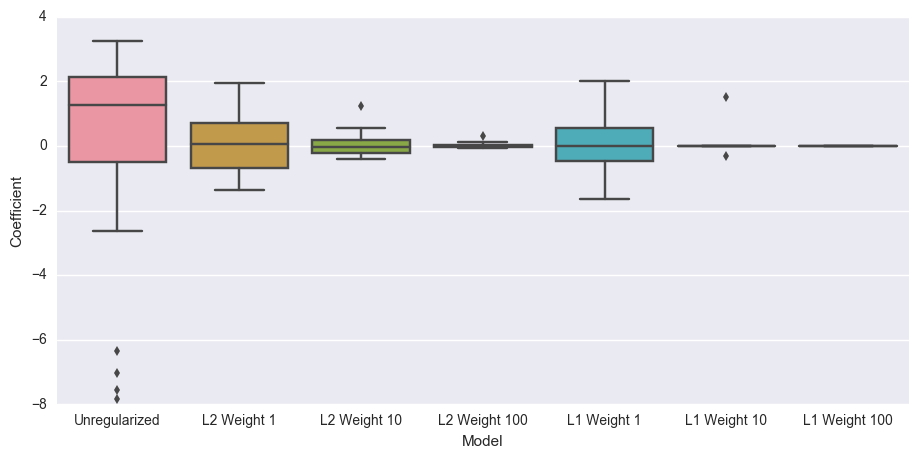

In [35]:
fig, ax = plt.subplots(figsize=(11,5))
sns.boxplot(y="Coefficient", x="Model" ,data=regularized_coefficients,orient="v",ax=ax)

regularized_coefficients.pivot("Label","Model","Coefficient").describe()

## Additional Automatically-Generated Features

#### Feature Generation

To improve the fit, I will attempt to automatically generate additional features.  I create a list of all unique words that appear in the "title" and "summary" columns, removing punctuation using the "CountVectorizer" function.  I then generate binary features for each selected word, with "1" indicating presence and "0" indicating absence.

I then apply two cuts to determine which words will be used as binary feature.  The first is the total number of entries a word appears in, while the second is the absolute value of the difference between the percentage of entries containing that word that have high salaries and the overall percentage.  These are both expected to be rough indicators of the significance of individual words.

In [36]:
from  sklearn.feature_extraction.text import CountVectorizer

tokenizer = CountVectorizer().build_tokenizer()

jobs["summary_tokenized"] = jobs["summary"].apply(tokenizer)
jobs["title_tokenized"] = jobs["title"].apply(tokenizer)

summary_unique_words = list(set(sum(list(jobs["summary_tokenized"]),[])))
title_unique_words = list(set(sum(list(jobs["title_tokenized"]),[])))

def cut_word_lists(min_entries, cut_threshold):
    summary_cut = [word for word in summary_unique_words if \
                   (jobs[jobs["summary"].apply(lambda x:word in x)].shape[0] > min_entries and \
    abs(jobs[jobs["summary"].apply(lambda x:word in x)]["high_low"].mean() - jobs["high_low"].mean()) > cut_threshold)]

    title_cut = [word for word in title_unique_words if \
                 (jobs[jobs["title"].apply(lambda x:word in x)].shape[0] > min_entries and \
    abs(jobs[jobs["title"].apply(lambda x:word in x)]["high_low"].mean() - jobs["high_low"].mean()) > cut_threshold)]
    
    return (summary_cut,title_cut)

def cut_dataset(min_entries, cut_threshold):
    y = jobs["high_low"]
    X = pd.get_dummies(jobs["city"],columns=["city"])
    X = sm.add_constant(X, prepend=False)

    summary_cut,title_cut = cut_word_lists(min_entries,cut_threshold)

    for word in summary_cut:
        X["summary_"+word] = jobs["summary"].apply(lambda x:int(word in " ".join(tokenizer(x))))
    
    for word in title_cut:
        X["title_"+word] = jobs["title"].apply(lambda x:int(word in " ".join(tokenizer(x))))
        
    return (X,y,len(summary_cut),len(title_cut))

Using the cuts described above, I generate the summary measures in the ranges given by "num_words_range" and "freq_range" using L2 regularization with a weight of 100.  Summary plots are included below.

In [37]:
num_words_range = range(0,21,2)
freq_range = range(0,401,25)

measures = []

for word_cut in num_words_range:
    for freq in freq_range:
        freq_cut = 1.0 * freq / 1000

        regression_for_cv = LogisticRegressionCV(penalty='l2',solver='liblinear',fit_intercept=False,Cs=[0.01])

        (X,y,summary_words,title_words) = cut_dataset(word_cut,freq_cut)

        measures.append({\
            "Word Cut":word_cut,\
            "Significance Cut":freq_cut,\
            "Summary Words":summary_words,\
            "Title Words":title_words,\
            "Accuracy":np.mean(cross_val_score(regression_for_cv,X,y,cv=10,scoring='accuracy')),\
            "ROC AUC":np.mean(cross_val_score(regression_for_cv,X,y,cv=10,scoring='roc_auc')),\
            "Precision":np.mean(cross_val_score(regression_for_cv,X,y,cv=10,scoring='precision')),\
            "Recall":np.mean(cross_val_score(regression_for_cv,X,y,cv=10,scoring='recall')),\
            "F1":np.mean(cross_val_score(regression_for_cv,X,y,cv=10,scoring='f1'))})

measures = pd.DataFrame(measures)
measures = measures[["Word Cut","Significance Cut","Summary Words","Title Words",
                     "Accuracy","ROC AUC","Precision","Recall","F1"]]

In [50]:
measures.head()

,Word Cut,Significance Cut,Summary Words,Title Words,Accuracy,ROC AUC,Precision,Recall,F1
0,0,0.000,2144,508,0.754597,0.836955,0.777773,0.693684,0.728932
1,0,0.025,1957,488,0.766917,0.848622,0.783983,0.718684,0.746072
2,0,0.050,1927,486,0.774109,0.855677,0.764429,0.789474,0.770005
3,0,0.075,1897,482,0.778987,0.862155,0.769237,0.794474,0.775603
4,0,0.100,1860,475,0.786304,0.864060,0.775607,0.799211,0.782142


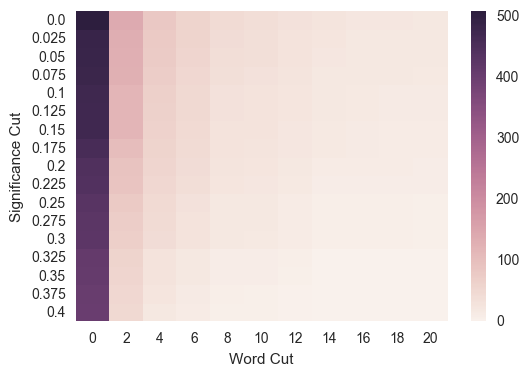

In [44]:
sns.heatmap(measures.pivot("Significance Cut","Word Cut","Title Words"))

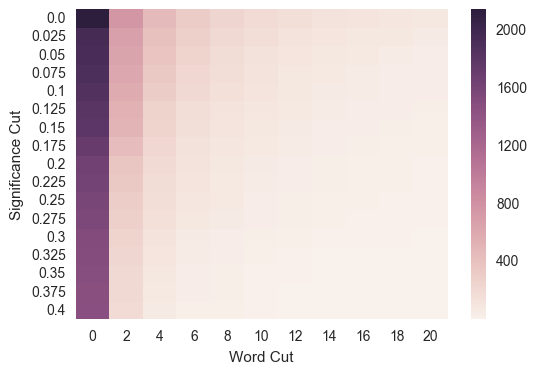

In [45]:
sns.heatmap(measures.pivot("Significance Cut","Word Cut","Summary Words"))

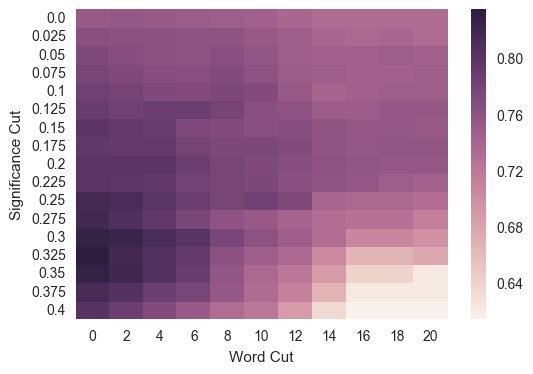

In [46]:
sns.heatmap(measures.pivot("Significance Cut","Word Cut","Accuracy"))

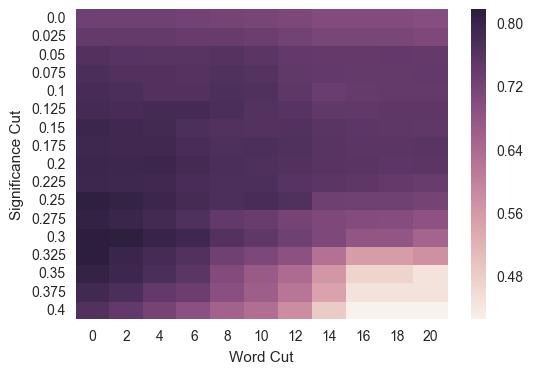

In [47]:
sns.heatmap(measures.pivot("Significance Cut","Word Cut","F1"))

#### Interpretation of Results

Interestingly, the best results for accuracy and F1 score occure with no word cut and a high significance cut.  The high significance cut is intuitively reasonable, as it is effectively a selection against common words which appear in sentences regardless of the sentence meaning, and thus should have no effect on the fit.  The best results for the word cut being no cut is more perplexing; one might expect that word which are present in only one or two entries would produce odd coefficients which would result in a poor fit during cross-validation.  It is possible that the L2 regularization scheme reduces this effect given the vast number of coefficients in play, up to more than 2500 for the weakest cuts.  However, even with cuts in place there are many models in the plots above with accuracies above 80% and high F1-scores.

The best values for out of sample accuracy and F1-score occur for the same cut values, namely a word cut of zero and a significance cut of 0.325.  All performance measures at this value are superior to the measures from the more conservative set of features considered above.  I also consider the best models for accuracy and F1-score with less than a hundred summary words as a proxy for performance with a more reasonable number of features, and the performance is still substantially better than the simple models considered previously.

In [56]:
measures[measures["Accuracy"] == measures["Accuracy"].max()]

,Word Cut,Significance Cut,Summary Words,Title Words,Accuracy,ROC AUC,Precision,Recall,F1
13,0,0.325,1512,413,0.83571,0.93354,0.884782,0.774737,0.819195


In [57]:
measures[measures["F1"] == measures["F1"].max()]

,Word Cut,Significance Cut,Summary Words,Title Words,Accuracy,ROC AUC,Precision,Recall,F1
13,0,0.325,1512,413,0.83571,0.93354,0.884782,0.774737,0.819195


In [63]:
rm = measures[measures["Summary Words"] < 100]
rm[rm["Accuracy"] == rm["Accuracy"].max()]

,Word Cut,Significance Cut,Summary Words,Title Words,Accuracy,ROC AUC,Precision,Recall,F1
48,4,0.35,87,28,0.806316,0.902838,0.88057,0.714474,0.774942


In [62]:
rm = measures[measures["Summary Words"] < 100]
rm[rm["F1"] == rm["F1"].max()]

,Word Cut,Significance Cut,Summary Words,Title Words,Accuracy,ROC AUC,Precision,Recall,F1
63,6,0.3,67,29,0.803377,0.869906,0.80946,0.789211,0.793694


## Conclusions

Using logistic regression, I have identified models for determining whether a given job posting in the data science field is high or low paying based upon location and words present in the title and summary entries of the posting.  I have considered models using only the job location, a presence or absence small hand-selected set of words in the title, and presence or absence of a larger automatically-generated set of words.  The best of the automatically generated models produced the best results, with the best have an accuracy of 83%, precision of 88%, and recall of 77%.  In layman's terms, this implies that 83% of the results of the model are expected to be correct, 88% of the jobs suggested highlighted by the model are expected to be high paying, and it is expected to identify 77% of the true high-paying jobs.   

However, there are some underlying concerns with the results from the larger feature selection algorithm.  The number of features for the best this case vastly outnumbers the number of entries.  Moreover, the features vectors are extremely sparse.  As such, the results may not be generalizable to larger data sets.  As such, I recommend either using a larger set of job data to produce more reliable results, as the number of unique words contained in the job titles and summaries should increase at a significantly less than linear rate with the number of entries.  It might also be reasonable to use a more conservative model with less features, some of which still have have both accuracy and precision above 80%.